In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2478616550472865447,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3127299278
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7932326225872661824
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [2]:
import segmentation_models as sm
import tensorflow as tf
from pycocotools.coco import COCO
from pathlib import Path
import numpy as np
from typing import Final
import plotly.express as px
from matplotlib import pyplot as plt
import cv2
from albumentations import Compose, VerticalFlip, HorizontalFlip, ShiftScaleRotate, RandomSizedCrop


Segmentation Models: using `tf.keras` framework.


In [3]:
image_size:Final[int] = 256

In [5]:
annotation_file = Path("data/annotations/instances_default.json")
coco = COCO(str(annotation_file))

for i in coco.getCatIds():
    if coco.loadCats(i)[0]["name"] == "Crack":
        cat_id = coco.loadCats(i)[0]["id"]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [8]:
def create_mask(anns, cat_id):
    mask = np.zeros((image_size, image_size, 1))
    for i in range(len(anns)):
        if anns[i]["category_id"] == cat_id:
            cv2.fillPoly(mask, pts=[np.array(anns[i]["segmentation"], dtype=np.int32).reshape(-1,1, 2)], color=(1))
    return mask

def read_data(idx, cat_id):
    anns = coco.loadAnns(coco.getAnnIds(idx))
    mask = create_mask(anns, cat_id)
    image = np.array(tf.keras.preprocessing.image.load_img(str(Path("data/images/annotated") / coco.loadImgs(idx)[0]["file_name"]))) / 255
    return image, mask

In [50]:
def file_load_generator(cat_id, coco, split=15, is_train=True):
    transform = Compose([VerticalFlip(), HorizontalFlip(), ShiftScaleRotate()])
    ids = coco.getImgIds()[:split] if is_train else coco.getImgIds()[split:]
    for idx in ids:
        image, mask = read_data(idx, cat_id)
        ret = transform(image=image, mask=mask)
        yield ret["image"], ret["mask"]

ds = tf.data.Dataset.from_generator(lambda: file_load_generator(cat_id, coco), (tf.float32, tf.float32)).batch(5)
for image, label in ds:
    img = image[0]
    lbl = label[0]

In [144]:
image, label = read_data(15, cat_id)

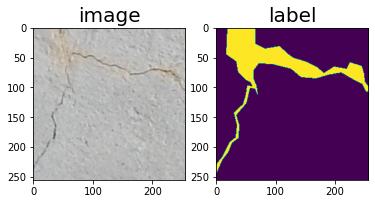

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("image",fontsize=20)
plt.imshow(image)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("label",fontsize=20)
plt.imshow(label)

In [127]:
def non_clack_generator(split=180, is_train=True):
    transform = Compose([VerticalFlip(), HorizontalFlip(), ShiftScaleRotate()])
    files = [f for f in Path("data/images/non_clack").glob("*")]
    files = files[:split] if is_train else files[split:]
    for file in files:
        image = np.expand_dims(tf.keras.preprocessing.image.load_img(file),axis=0)
        ret = transform(image=image)
        yield ret["image"], ret["image"]

In [140]:
train_ds = tf.data.Dataset.from_generator(lambda: file_load_generator(cat_id, coco), (tf.float32, tf.float32)).batch(5)
test_ds = tf.data.Dataset.from_generator(lambda: file_load_generator(cat_id, coco, is_train=False), (tf.float32, tf.float32))

non_clack_images = [np.expand_dims(tf.keras.preprocessing.image.load_img(p),axis=0) for p in Path("data/images/non_clack").glob("*")]
non_clack_images = np.concatenate(non_clack_images) / 255

recon_train_ds = tf.data.Dataset.from_tensor_slices((non_clack_images[:180,:,:,:], non_clack_images[:180,:,:,:])).batch(8)
recon_test_ds = tf.data.Dataset.from_tensor_slices((non_clack_images[180:,:,:,:], non_clack_images[180:,:,:,:]))

#recon_train_ds = tf.data.Dataset.from_generator(lambda: non_clack_generator(), (tf.float32, tf.float32)).batch(8)
#recon_test_ds = tf.data.Dataset.from_generator(lambda: non_clack_generator(is_train=False), (tf.float32, tf.float32))

In [29]:
try:
    segment_model = tf.keras.models.load_model("segmentation.hf5")
except:
    segment_model = sm.Unet(input_shape=(256, 256, 3))

class ClackAnnotNet(tf.keras.Model):
    def __init__(self):
        super(ClackAnnotNet, self).__init__()
        self.model = sm.Unet(input_shape=(256, 256, 3), classes=3)
        self.model = tf.keras.Model(inputs=self.model.input, outputs=self.model.get_layer("final_conv").output)
        self.model = tf.keras.Sequential([self.model, tf.keras.layers.Activation("sigmoid", name="Sigmoid")])
    def call(self, inputs):
        return self.model(inputs)

try:
    model = tf.keras.models.load_model("reconstruct.hf5")
except:
    model = ClackAnnotNet()

## 再構成モデル

In [138]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
model.fit(recon_train_ds, epochs=1000, validation_data=recon_test_ds, callbacks=[callback])

Epoch 1/1000
23/23 [==============================] - 19s 758ms/step - loss: 2.6931e-04 - val_loss: 0.0014
Epoch 2/1000
23/23 [==============================] - 16s 692ms/step - loss: 3.0463e-04 - val_loss: 0.0013
Epoch 3/1000
23/23 [==============================] - 16s 684ms/step - loss: 2.7788e-04 - val_loss: 4.3864e-04
Epoch 4/1000
23/23 [==============================] - 15s 667ms/step - loss: 2.6806e-04 - val_loss: 3.5493e-04
Epoch 5/1000
23/23 [==============================] - 15s 667ms/step - loss: 2.6256e-04 - val_loss: 2.2297e-04
Epoch 6/1000
23/23 [==============================] - 16s 710ms/step - loss: 2.5900e-04 - val_loss: 3.0397e-04
Epoch 7/1000
23/23 [==============================] - 16s 696ms/step - loss: 2.6216e-04 - val_loss: 7.5065e-04
Epoch 8/1000
23/23 [==============================] - 16s 686ms/step - loss: 2.6271e-04 - val_loss: 2.6105e-04
Epoch 9/1000
23/23 [==============================] - 15s 662ms/step - loss: 2.7049e-04 - val_loss: 4.4475e-04
Epoch 10/

## セグメンテーションモデル

In [45]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

#segment_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy",metrics=["binary_crossentropy"])
segment_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mae",metrics=["mae"])
segment_model.fit(train_ds, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 4s 457ms/step - loss: 0.0773 - mae: 0.0773
Epoch 2/1000
4/4 [==============================] - 2s 455ms/step - loss: 0.1224 - mae: 0.1224
Epoch 3/1000
4/4 [==============================] - 2s 456ms/step - loss: 0.1064 - mae: 0.1064
Epoch 4/1000
4/4 [==============================] - 2s 460ms/step - loss: 0.0856 - mae: 0.0856
Epoch 5/1000
4/4 [==============================] - 2s 454ms/step - loss: 0.0841 - mae: 0.0841
Epoch 6/1000
4/4 [==============================] - 2s 448ms/step - loss: 0.0761 - mae: 0.0761
Epoch 7/1000
4/4 [==============================] - 2s 452ms/step - loss: 0.0726 - mae: 0.0726
Epoch 8/1000
4/4 [==============================] - 2s 453ms/step - loss: 0.0758 - mae: 0.0758
Epoch 9/1000
4/4 [==============================] - 2s 456ms/step - loss: 0.0683 - mae: 0.0683
Epoch 10/1000
4/4 [==============================] - 2s 454ms/step - loss: 0.0650 - mae: 0.0650
Epoch 11/1000
4/4 [==============================

In [156]:
model.save("reconstruct")
segment_model.save("segmentation")

INFO:tensorflow:Assets written to: reconstruct\assets
INFO:tensorflow:Assets written to: segmentation\assets


## 可視化

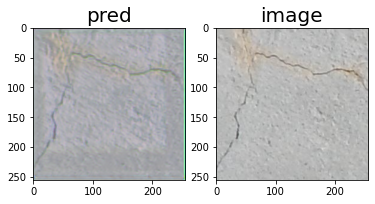

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("pred",fontsize=20)
plt.imshow(model(tf.expand_dims(image, axis=0))[0])
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("image",fontsize=20)
plt.imshow(image)

4972

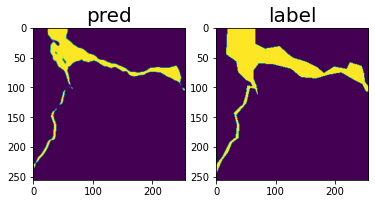

In [82]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("pred",fontsize=20)
plt.imshow(segment_model(tf.expand_dims(image, axis=0))[0])
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("label",fontsize=20)
plt.imshow(label)

t=segment_model(tf.expand_dims(image, axis=0))[0].numpy()
#tf.reduce_sum(tf.where(tf.greater(t,), t, tf.zeros_like(t)))
len(np.where(t>0.1)[0])

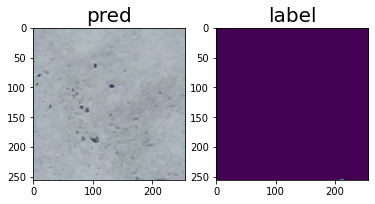

In [139]:
nc_image = non_clack_images[180]

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("pred",fontsize=20)
plt.imshow(nc_image)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("label",fontsize=20)
plt.imshow((tf.keras.losses.MSE(model(np.expand_dims(nc_image, axis=0)), nc_image).numpy()[0] > 0.01) * 255)

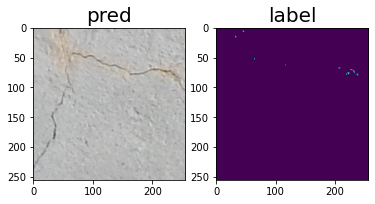

In [145]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("pred",fontsize=20)
plt.imshow(image)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("label",fontsize=20)
plt.imshow((tf.keras.losses.MSE(model(np.expand_dims(image, axis=0)), image).numpy()[0] > 0.01) * 255)

## 特徴空間分離

In [152]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

feature_model = model.get_layer("sequential_1").get_layer("model_12")
feature_model = tf.keras.Model(inputs=feature_model.input, outputs=feature_model.get_layer("block3_pool").output)

# 特徴量抽出モデル
test = train_ds.unbatch()
#a_x = [tf.keras.losses.MAE(model(np.expand_dims(x, axis=0)), x).numpy().flatten() for x, y in test]
a_x = [feature_model(np.expand_dims(x, axis=0)).numpy().flatten() for x, y in test]
a_y = [0] * len(a_x)
a_c = ["ひびあり"] * len(a_x)

a_n = []
for idx in coco.getImgIds()[:15]:
    anns = coco.loadAnns(coco.getAnnIds(idx))
    a_n.append(coco.loadImgs(idx)[0]["file_name"])


unb_test = recon_train_ds.unbatch()
#b_x = [tf.keras.losses.MAE(model(np.expand_dims(x, axis=0)), x).numpy().flatten() for x, y in unb_test]
b_x = [feature_model(np.expand_dims(x, axis=0)).numpy().flatten() for x, y in unb_test]
b_y = [1] * len(b_x)
b_c = ["ひびなし"] * len(b_x)
b_n = [str(p.name) for p in Path("./data/images/non_clack").glob("*")]

a_x.extend(b_x)
a_y.extend(b_y)
a_c.extend(b_c)
a_n.extend(b_n[:180])

feature  = TSNE(n_components=2).fit_transform(np.array(a_x))

print(len(a_x), len(a_c), len(a_n))

plot_df = pd.DataFrame({"f1":feature[:, 0],"f2":feature[:, 1],"color":a_c, "name":a_n})

#plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, color=a_c)
fig = px.scatter(plot_df, x="f1", y="f2", color="color", hover_name="name" )
fig.update_layout(width=800, height=600)

c:\Users\hirose.tomoki\Desktop\concrete_annotation\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hirose.tomoki\Desktop\concrete_annotation\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


195 195 195


In [154]:
#result = tf.concat([tf.concat([model(image) for image, _, in test_ds], axis=0), tf.concat([model(image) for image, _, in recon_test_ds], axis=0)], axis=0)
#score = [len(np.where(t.numpy()>0.1)[0]) for t in result]

#score

counts = []

for image,_ in test_ds:
    result = (tf.keras.losses.MSE(model(np.expand_dims(image, axis=0)), image).numpy()[0] > 0.001) * 255
    counts.append(len(np.where(result==255)[0]))

for image,_ in recon_test_ds:
    result = (tf.keras.losses.MSE(model(np.expand_dims(image, axis=0)), image).numpy()[0] > 0.001) * 255
    counts.append(len(np.where(result==255)[0]))

labels = [1]*5
labels.extend([0]*20)


from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, th = roc_curve(labels, counts, drop_intermediate=False)
fpr, tpr, th



(array([0.  , 0.05, 0.05, 0.05, 0.05, 0.1 , 0.1 , 0.15, 0.2 , 0.25, 0.3 ,
        0.35, 0.4 , 0.45, 0.5 , 0.55, 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ,
        0.85, 0.9 , 0.95, 1.  ]),
 array([0. , 0. , 0.2, 0.4, 0.6, 0.6, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
        0.8, 0.8, 0.8, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]),
 array([1314, 1313, 1080, 1044, 1030,  902,  869,  738,  691,  520,  518,
         506,  505,  496,  484,  450,  449,  409,  401,  375,  373,  369,
         313,  296,  209,  201]))

In [155]:
roc_auc_score(labels, counts)

0.8400000000000001

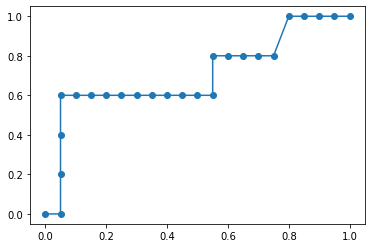

In [147]:
plt.plot(fpr, tpr, marker='o')